In [6]:
import os
import torch
from torchvision import io
from torch.utils.cpp_extension import load_inline
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

In [8]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'

In [9]:
img = io.read_image(urlretrieve(url)[0])

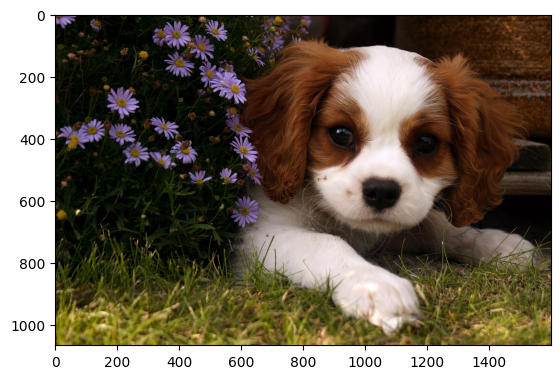

In [10]:
plt.imshow(img.cpu().numpy().transpose(1,2,0))

In [7]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [29]:
cuda_begin = r'''
#include <torch/extension.h>
#include <iostream>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [212]:
cuda_src = cuda_begin + r"""
__global__ void blur_kernel(uint8_t *in, uint8_t *out, uint32_t h, uint32_t w, int32_t blur_radius) {
  int32_t outRow = blockDim.y * blockIdx.y + threadIdx.y;
  int32_t outCol = blockDim.x * blockIdx.x + threadIdx.x;
  if (outRow >= h || outCol >= w) return;

  uint32_t r = 0, g = 0, b = 0, D = 0;
  for (int32_t inRow = outRow - blur_radius; inRow <= outRow + blur_radius; ++inRow) {
    for (int32_t inCol = outCol - blur_radius; inCol <= outCol + blur_radius; ++inCol) {
      if (inRow >= 0 && inRow < h && inCol >= 0 && inCol < w) {
        r += in[inRow * w + inCol];
        g += in[inRow * w + inCol + h * w];
        b += in[inRow * w + inCol + 2 * h * w];
        ++D;
      }
    }
  }
  out[outRow * w + outCol] = r / D;
  out[outRow * w + outCol + h * w] = g / D;
  out[outRow * w + outCol + 2 * h * w] = b / D;
}

at::Tensor blur(at::Tensor x, uint32_t blur_radius) {
  CHECK_INPUT(x);
  uint32_t c = x.size(0);
  uint32_t h = x.size(1);
  uint32_t w = x.size(2);
  at::Tensor y = at::empty_like(x);

  dim3 numThreads(32, 32);
  dim3 numBlocks(cdiv(w,numThreads.x), cdiv(h,numThreads.y));
  blur_kernel<<<numBlocks, numThreads>>>(x.data_ptr<uint8_t>(), y.data_ptr<uint8_t>(), h, w, blur_radius);

  return y;
}

__global__ void rgb2gray_kernel(uint8_t *in, uint8_t *out, uint32_t h, uint32_t w) {
  int32_t row = blockDim.y * blockIdx.y + threadIdx.y;
  int32_t col = blockDim.x * blockIdx.x + threadIdx.x;
  if (row >= h || col >= w) return;

  
  uint8_t r = in[row * w + col];
  uint8_t g = in[row * w + col + h * w];
  uint8_t b = in[row * w + col + 2 * h * w];
  out[row * w + col] = 0.21 * r + 0.72 * g + 0.07 * b;
}

at::Tensor rgb2gray(at::Tensor x) {
  CHECK_INPUT(x);
  int32_t h = x.size(1), w = x.size(2);
  at::Tensor y = at::empty({h, w}, x.options());

  dim3 numThreads(32, 32);
  dim3 numBlocks(cdiv(w,numThreads.x), cdiv(h,numThreads.y));
  rgb2gray_kernel<<<numBlocks, numThreads>>>(x.data_ptr<uint8_t>(), y.data_ptr<uint8_t>(), h, w);

  return y;
}
"""

cpp_src = """
at::Tensor blur(at::Tensor x, uint32_t blur_radius);
at::Tensor rgb2gray(at::Tensor x);
"""

In [215]:
module = load_inline(name='inline_extension',cpp_sources=[cpp_src], cuda_sources=[cuda_src], functions=['blur', 'rgb2gray'])

/home/akash/miniconda3/envs/playground/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [216]:
blur_img = module.blur(img.contiguous().cuda(), 50)
gray_img = module.rgb2gray(img.contiguous().cuda())

(np.float64(-0.5), np.float64(1599.5), np.float64(1065.5), np.float64(-0.5))

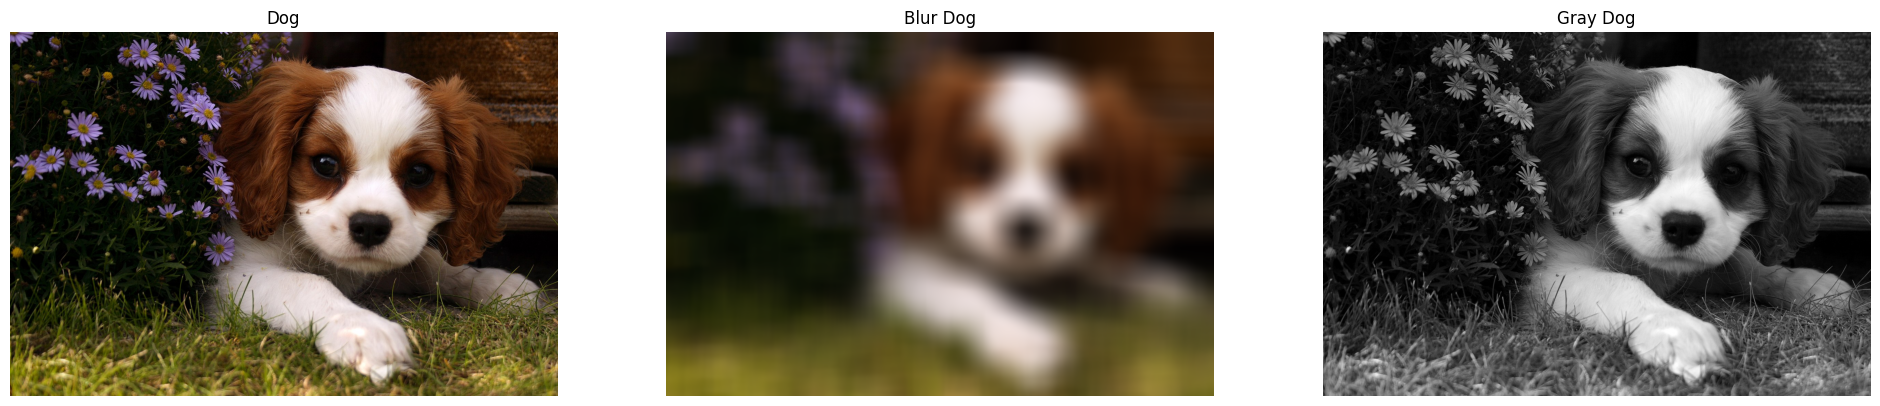

In [228]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8 * 3, 8))
axes[0].imshow(img.cpu().numpy().transpose(1, 2, 0))
axes[0].set_title('Dog')
axes[0].axis('off')
axes[1].imshow(blur_img.cpu().numpy().transpose(1, 2, 0))
axes[1].set_title('Blur Dog')
axes[1].axis('off')
axes[2].imshow(gray_img.cpu().numpy(), cmap='gray')
axes[2].set_title('Gray Dog')
axes[2].axis('off')
# plt.imshow(img.cpu().numpy().transpose(1, 2, 0))